In [1]:
%pylab inline
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib.cm as cm
import matplotlib.figure as fig
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib.ticker as mticker
import numpy as np
import numpy.ma as ma
from scipy.ndimage import label, generate_binary_structure
from collections import Counter
import xarray as xr 
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy import config
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import os
import netCDF4 as nc
from netCDF4 import Dataset
# from mpl_toolkits.basemap import Basemap

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Grab defined variables from MERRA

#fl = nc.MFDataset('/data/slasher/a/engelse2/ATMS507/MERRA100.prod.assim.instM_3d_asm_Cp.*') 
#fl = nc.MFDataset('/Users/engelse2/Desktop/ATMS507/MERRA/MERRA100.prod.assim.instM_3d_asm_Cp.*') 

In [3]:
# time = fl.variables['time']             #1d
# dtime = nc.num2date(time[:],time.units)
# levels = fl.variables['levels']      #1d
# #levels850 = fl.variables['levels'][6]      #1d
# lons = fl.variables['longitude']     #1d
# lats = fl.variables['latitude']      #1d
# u = fl.variables['u'][:]             #3d   (time,level,lon,lat)
# v = fl.variables['v'][:]             #3d             
# qv = fl.variables['qv'][:]           #3d
# rh = fl.variables['rh'][:]           #3d
# T = fl.variables['t'][:,6,:,:]                #3d  
# Tavg = np.mean(T,axis=0)

In [4]:
#ds = xr.open_mfdataset('/data/slasher/a/engelse2/ATMS507/MERRA100.prod.assim.instM_3d_asm_Cp.*')
#ds = xr.open_dataset('/Users/engelse2/Desktop/ATMS507/MERRA/MERRA100.prod.assim.instM_3d_asm_Cp.197901.SUB.nc', decode_times=False)
ds = xr.open_mfdataset('/Users/engelse2/Desktop/ATMS507/MERRA/MERRA100.prod.assim.instM_3d_asm_Cp.*')

In [5]:
ds

<xarray.Dataset>
Dimensions:    (latitude: 144, levels: 42, longitude: 288, time: 168)
Coordinates:
  * levels     (levels) float64 1e+03 975.0 950.0 925.0 900.0 875.0 850.0 ...
  * longitude  (longitude) float64 -179.4 -178.1 -176.9 -175.6 -174.4 -173.1 ...
  * latitude   (latitude) float64 -89.38 -88.12 -86.88 -85.62 -84.38 -83.12 ...
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 1979-03-01 ...
Data variables:
    qv         (time, levels, latitude, longitude) float64 dask.array<shape=(168, 42, 144, 288), chunksize=(1, 42, 144, 288)>
    rh         (time, levels, latitude, longitude) float64 dask.array<shape=(168, 42, 144, 288), chunksize=(1, 42, 144, 288)>
    t          (time, levels, latitude, longitude) float64 dask.array<shape=(168, 42, 144, 288), chunksize=(1, 42, 144, 288)>
    u          (time, levels, latitude, longitude) float64 dask.array<shape=(168, 42, 144, 288), chunksize=(1, 42, 144, 288)>
    v          (time, levels, latitude, longitude) float64 dask.arr

In [6]:
# Indexing arrays

ds_850 = ds.sel(time=slice('1978-01-01', '2015-01-02')).isel(levels=6)
#ds_box = ds.sel(time=slice('1978-01-01', '2015-01-02')).sel(longitude=slice(-89.375,-86.875)).sel(latitude=slice(39.375,40.625))
ds_box = ds.sel(time=slice('1978-01-01', '2015-01-02')).sel(longitude=-88.125).sel(latitude=39.375)


Tavgbox = ds_box['t'].groupby('time.month').mean('time')
RHavgbox = ds_box['rh'].groupby('time.month').mean('time')
Pavgbox = ds['levels']
Tavg = ds_850['t'].groupby('time.month').mean('time')
RHavg = ds_850['rh'].groupby('time.month').mean('time')
lons = ds['longitude']
lats = ds['latitude']
# T = ds['t']

In [7]:
ds_box

<xarray.Dataset>
Dimensions:    (levels: 42, time: 168)
Coordinates:
  * levels     (levels) float64 1e+03 975.0 950.0 925.0 900.0 875.0 850.0 ...
    longitude  float64 -88.12
    latitude   float64 39.38
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 1979-03-01 ...
Data variables:
    qv         (time, levels) float64 dask.array<shape=(168, 42), chunksize=(1, 42)>
    rh         (time, levels) float64 dask.array<shape=(168, 42), chunksize=(1, 42)>
    t          (time, levels) float64 dask.array<shape=(168, 42), chunksize=(1, 42)>
    u          (time, levels) float64 dask.array<shape=(168, 42), chunksize=(1, 42)>
    v          (time, levels) float64 dask.array<shape=(168, 42), chunksize=(1, 42)>
Attributes:
    Conventions:  COARDS
    calendar:     standard
    comments:     file created by grads using lats4d available from http://da...
    model:        geos/das
    center:       gsfc

In [8]:
Tavgbox

<xarray.DataArray 't' (month: 12, levels: 42)>
dask.array<shape=(12, 42), dtype=float64, chunksize=(1, 42)>
Coordinates:
  * levels     (levels) float64 1e+03 975.0 950.0 925.0 900.0 875.0 850.0 ...
    longitude  float64 -88.12
    latitude   float64 39.38
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [9]:
Pavgbox

<xarray.DataArray 'levels' (levels: 42)>
array([  1.000000e+03,   9.750000e+02,   9.500000e+02,   9.250000e+02,
         9.000000e+02,   8.750000e+02,   8.500000e+02,   8.250000e+02,
         8.000000e+02,   7.750000e+02,   7.500000e+02,   7.250000e+02,
         7.000000e+02,   6.500000e+02,   6.000000e+02,   5.500000e+02,
         5.000000e+02,   4.500000e+02,   4.000000e+02,   3.500000e+02,
         3.000000e+02,   2.500000e+02,   2.000000e+02,   1.500000e+02,
         1.000000e+02,   7.000000e+01,   5.000000e+01,   4.000000e+01,
         3.000000e+01,   2.000000e+01,   1.000000e+01,   7.000000e+00,
         5.000000e+00,   4.000000e+00,   3.000000e+00,   2.000000e+00,
         1.000000e+00,   7.000000e-01,   5.000000e-01,   4.000000e-01,
         3.000000e-01,   1.000000e-01])
Coordinates:
  * levels   (levels) float64 1e+03 975.0 950.0 925.0 900.0 875.0 850.0 ...
Attributes:
    units:        hPa
    description:  Pressure level
    type:         plev
    long_name:    Level
    po

In [10]:
Tavg_jan = Tavg[0,:,:]
Tavg_jul = Tavg[6,:,:]
Tavgbox_jan = Tavgbox[0,:]-273.15
Tavgbox_jul = Tavgbox[6,:]-273.15
RHavgbox_jan = RHavgbox[0,:]*100
RHavgbox_jul = RHavgbox[6,:]*100
Tavg_diff = Tavg_jul - Tavg_jan
RHavg_jan = RHavg[0,:,:]
RHavg_jul = RHavg[6,:,:]
RHavg_diff = RHavg_jul - RHavg_jan

/Users/engelse2/anaconda3/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


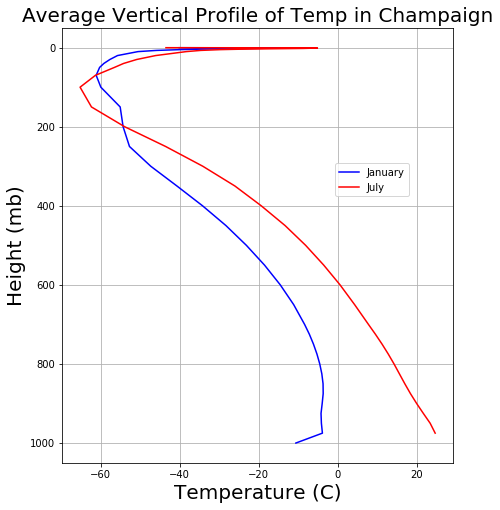

In [11]:
plt.figure(figsize=(7,8))
# plt.yscale('log')
ax = plt.gca().invert_yaxis()

plt.xlabel('Temperature (C)', fontsize=20)
plt.ylabel('Height (mb)', fontsize=20)
plt.title('Average Vertical Profile of Temp in Champaign', fontsize=20)
grid('on')
plt.plot(Tavgbox_jan,Pavgbox,color="Blue",label="January")
plt.plot(Tavgbox_jul,Pavgbox,color="Red",label="July")
plt.legend(bbox_to_anchor=(.9, 0.7), loc=1)

/Users/engelse2/anaconda3/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


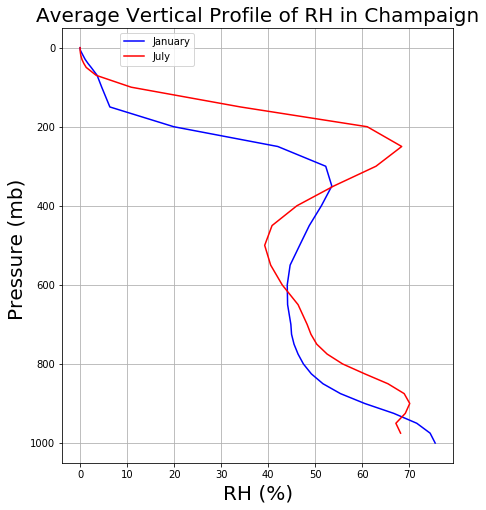

In [12]:
plt.figure(figsize=(7,8))
# plt.yscale('log')
ax = plt.gca().invert_yaxis()

plt.xlabel('RH (%)', fontsize=20)
plt.ylabel('Pressure (mb) ', fontsize=20)
plt.title('Average Vertical Profile of RH in Champaign', fontsize=20)
grid('on')
plt.plot(RHavgbox_jan,Pavgbox,color="Blue",label="January")
plt.plot(RHavgbox_jul,Pavgbox,color="Red",label="July")
plt.legend(bbox_to_anchor=(.35, 1.0), loc=1)

/Users/engelse2/anaconda3/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


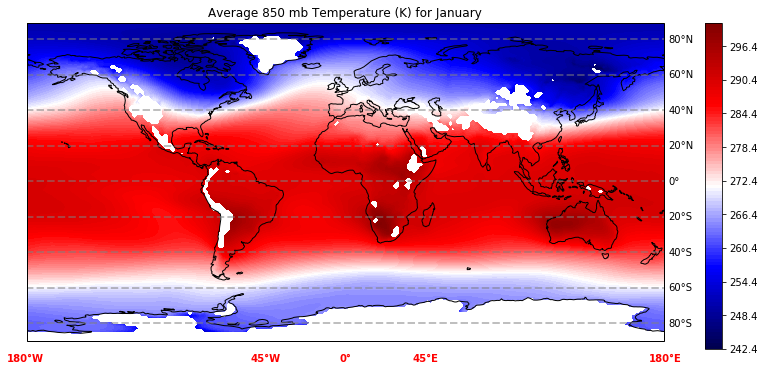

In [13]:
plt.figure(figsize=(15,6))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlines = False
gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 15, 'color': 'gray'}
gl.xlabel_style = {'color': 'red', 'weight': 'bold'}

plt.title('Average 850 mb Temperature (K) for January')

img = plt.contourf(lons,lats,Tavg_jan, 100, cmap='seismic',
             transform=ccrs.PlateCarree())

plt.colorbar(img)
plt.show(img)


In [14]:
Tavg_jan.shape

(144, 288)

/Users/engelse2/anaconda3/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


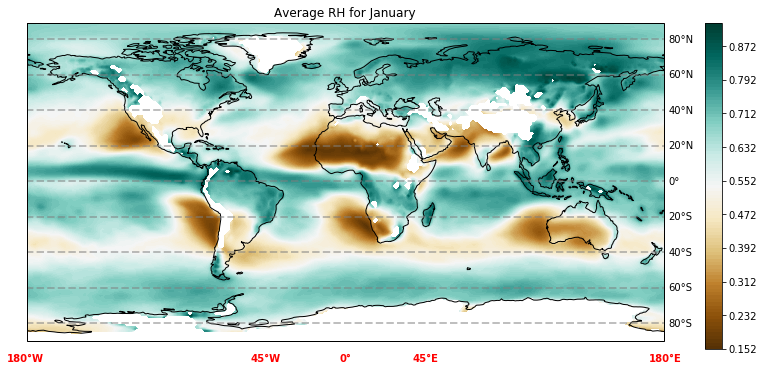

In [17]:
plt.figure(figsize=(15,6))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlines = False
gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 15, 'color': 'gray'}
gl.xlabel_style = {'color': 'red', 'weight': 'bold'}

plt.title('Average RH for January')

img1 = plt.contourf(lons,lats,RHavg_jan, 100, cmap='BrBG',
             transform=ccrs.PlateCarree())
plt.colorbar(img1)

plt.show(img1)


/Users/engelse2/anaconda3/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


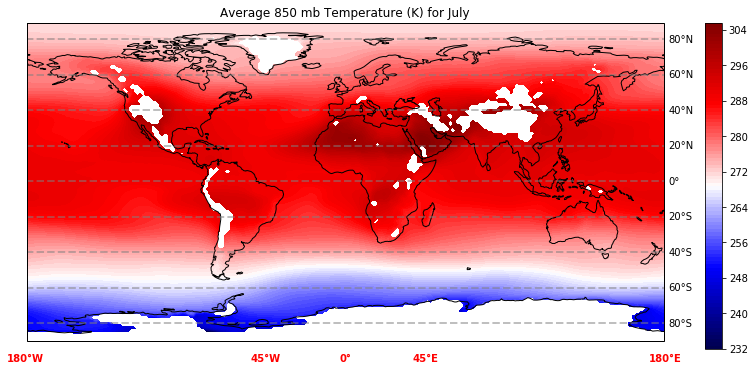

In [18]:
plt.figure(figsize=(15,6))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlines = False
gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 15, 'color': 'gray'}
gl.xlabel_style = {'color': 'red', 'weight': 'bold'}

plt.title('Average 850 mb Temperature (K) for July')

img2 = plt.contourf(lons,lats,Tavg_jul, 100, cmap='seismic',
             transform=ccrs.PlateCarree())
plt.colorbar(img2)

plt.show(img2)


/Users/engelse2/anaconda3/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


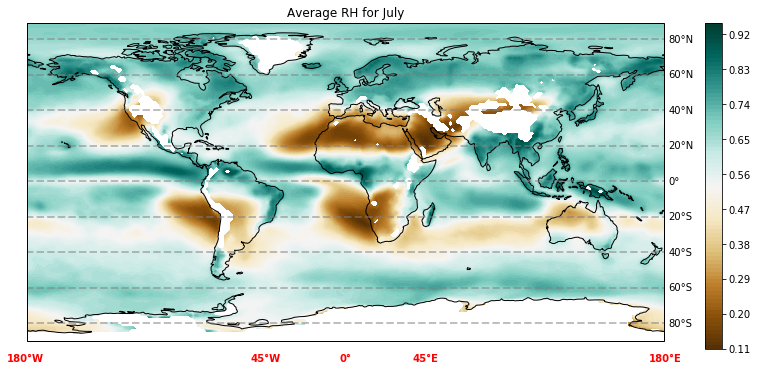

In [19]:
plt.figure(figsize=(15,6))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlines = False
gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 15, 'color': 'gray'}
gl.xlabel_style = {'color': 'red', 'weight': 'bold'}

plt.title('Average RH for July')

img3 = plt.contourf(lons,lats,RHavg_jul, 100, cmap='BrBG',
             transform=ccrs.PlateCarree())
plt.colorbar(img3)

plt.show(img3)


/Users/engelse2/anaconda3/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


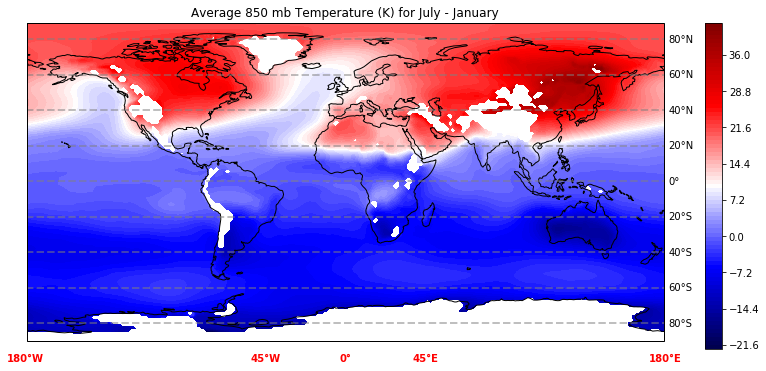

In [20]:
plt.figure(figsize=(15,6))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlines = False
gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 15, 'color': 'gray'}
gl.xlabel_style = {'color': 'red', 'weight': 'bold'}

plt.title('Average 850 mb Temperature (K) for July - January')

img4 = plt.contourf(lons,lats,Tavg_diff, 100, cmap='seismic',
             transform=ccrs.PlateCarree())
plt.colorbar(img4)

plt.show(img4)


/Users/engelse2/anaconda3/lib/python3.6/site-packages/dask/array/numpy_compat.py:46: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


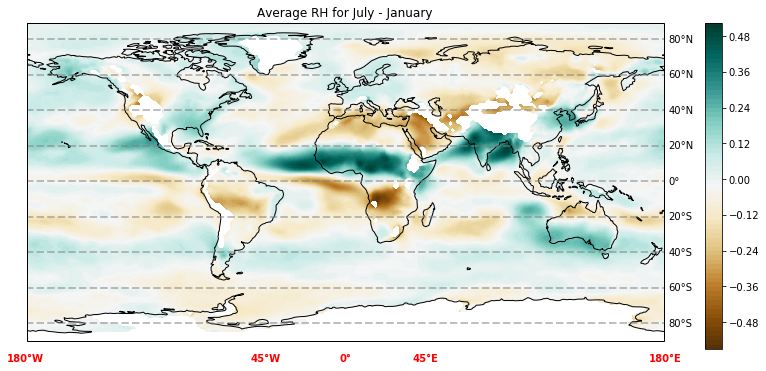

In [21]:
plt.figure(figsize=(15,6))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlines = False
gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 15, 'color': 'gray'}
gl.xlabel_style = {'color': 'red', 'weight': 'bold'}

plt.title('Average RH for July - January')

img5 = plt.contourf(lons,lats,RHavg_diff, 100, cmap='BrBG',
             transform=ccrs.PlateCarree())
plt.colorbar(img5)

plt.show(img5)
